# Initial

In [ ]:
# Set Working Directory 
import os 
os.chdir("/Users/Nico/Downloads/Datathon")
os.getcwd()

### Loading Programs 
---

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
import seaborn as sns
import shap
from sklearn.metrics import classification_report
import openpyxl
from itertools import cycle
import scipy
from scipy.stats import zscore

# Check Version 
print("scikit-learn version:", sklearn.__version__)
print("NumPy version:", np.__version__)
print("XGBoost version:", xgb.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("SHAP version:", shap.__version__)
print("Scipy version:", scipy.__version__)

scikit-learn version: 1.4.2
NumPy version: 1.26.4
XGBoost version: 2.0.3
Pandas version: 2.2.2
Seaborn version: 0.13.2
Matplotlib version: 3.9.0
Seaborn version: 0.13.2
SHAP version: 0.45.1
Scipy version: 1.13.0


/Users/guntaasshergill/miniconda/envs/general/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing Data
---

In [4]:
# Import all data sets
G3_Train_temp = pd.read_csv('Non-Hospice Discharge Train.csv')
G3_Test = pd.read_csv('Non-Hospice Discharge Test No Lables.csv')
G1 = pd.read_csv('Died During Admission.csv')
G2 = pd.read_csv('Discharged to Hospice.csv')

# Label G3_Test
G3_Test['Test'] = True

In [5]:
# Concatenate
G3_All = pd.concat([G3_Train_temp, G1, G2, G3_Test])
G3_All = G3_All.reset_index(drop=True)

In [6]:
# Make sure concatenation occured appropriately
print(G3_All.shape)
print(G3_Train_temp.shape)
print(G1.shape)
print(G2.shape)
print(G3_Test.shape)

(4745, 232)
(3072, 231)
(498, 231)
(407, 231)
(768, 230)


In [7]:
# Binarize test column 
G3_All['Test'] = G3_All['Test'].apply(lambda x: True if x== True else False)

# Gender at Birth (Male) column creation (one hot encoding)
G3_All['gender at birth (male)'] = ''
G3_All['gender at birth (male)'] = G3_All['gender at birth'].apply(lambda x : True if x == 'MALE' else False)
G3_All = G3_All.drop(columns=['gender at birth'])

In [8]:
# Mapping of Groups
Dispo_OneHot = pd.get_dummies(G3_All['dispo']) # Perform One Hot Encoding

current_columns = Dispo_OneHot.columns.tolist()
current_columns[0] = 'Discharged Not Hospice'
Dispo_OneHot.columns = current_columns

G3_All = pd.concat([G3_All, Dispo_OneHot], axis=1) # Concat One Hot encoded features to main DataFrame

# Remove Dispo
G3_All = G3_All.drop(columns='dispo')
Dispo_OneHot

,Discharged Not Hospice,Discharged Deceased,Discharged Hospice
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4740,True,False,False
4741,True,False,False
4742,True,False,False
4743,True,False,False


### Features
---

##### Engineer BMI

In [9]:
stages = ['- first', '- last', '- min', '- max']
for i in stages:
    G3_All['BMI' + i] = G3_All['weight' + i] / ((G3_All['height'] / 100) ** 2)

In [10]:
# Obtain all columns with first, last, max, min measurements
cols_of_interest = G3_All.loc[:,G3_All.columns.to_series().apply(lambda x: x.rsplit(' ',1)[-1] in ['first', 'last', 'max', 'min'])]

# Obtain what features all these first, last, max and min measurements are describing 
cols_of_interest_temp = cols_of_interest.columns.to_series().apply(lambda x: x.rsplit(' ',1)[0])
cols_of_interest_unique = cols_of_interest_temp.unique()

# Obtain number of measurement types for each feature 
cols_of_interest_n = cols_of_interest_temp.value_counts()

# Check data conformancy
cols_of_interest_unique.shape[0] == cols_of_interest_n.shape[0]

# Print unique features with max, min, first and last values
print(cols_of_interest_unique)

for x in cols_of_interest_unique:
    for y in range(len(G3_All)):
        if '-' in x:
            if ((x + ' max') in cols_of_interest.columns) & ((x + ' min') in cols_of_interest.columns): # making sure the columns are present
                if pd.notna(G3_All.loc[y, x + ' max']) & pd.notna(G3_All.loc[y, x + ' min']): # making sure the individual values are not null
                    G3_All.loc[y,x + ' difference between max & min measurement'] = G3_All.loc[y, x + ' max'] - G3_All.loc[y, x + ' min']

['ammonia -' 'bicarb-' 'rr-' 'temp-' 'weight-' 'sbp-' 'dbp-' 'plt-'
 'wbc -' 'hb-' 'ap-' 'ggt-' 'spo2-' 'potassium-' 'creatinine -' 'sodium-'
 'troponin - i-' 'bilirubin total-' 'ast-' 'alt-' 'bun-' 'albumin-'
 'lactate-' 'pro-bnp-' 'BMI-']


##### Engineer Sofa Scores

In [11]:
# Create function for sofa respiratory score
def calculate_sofa_respiratory(SpO2):
    if SpO2 < 80:
        return 3
    elif 80 <= SpO2 <= 89:
        return 2
    elif 90 <= SpO2 <= 93:
        return 1
    elif SpO2 > 93:
        return 0

# Create function for sofa coagulation score
def calculate_sofa_coagulation(plt):
    if plt > 150:
        return 0
    elif 100 < plt <= 150:
        return 1
    elif 50 < plt <= 100:
        return 2
    elif 20 < plt <= 50:
        return 3
    elif plt <= 20:
        return 4
    
# Create function for sofa liver score
def calculate_sofa_liver(bilirubin):
    if bilirubin <= 1.2:
        return 0
    elif 1.2 < bilirubin <= 1.9:
        return 1
    elif 2.0 <= bilirubin <= 5.9:
        return 2
    elif 6.0 <= bilirubin <= 11.9:
        return 3
    elif bilirubin >= 12.0:
        return 4
    
# Create function for sofa cardiovascular score
def calculate_sofa_cardiovascular(MAP):
    if MAP >= 70:
        return 0
    elif 60 <= MAP <= 69:
        return 1
    elif 50 <= MAP <= 59:
        return 2
    elif MAP < 50:
        return 3
    
# Create function for sofa sofa score
def calculate_sofa_renal(creatinine):
    if creatinine < 1.2:
        return 0
    elif 1.2 < creatinine <= 1.9:
        return 1
    elif 2.0 <= creatinine <= 3.4:
        return 2
    elif 3.5 <= creatinine <= 4.9:
        return 3
    elif creatinine >= 5.0:
        return 4

### Engineer SOFA Score, MAP and Pulse Pressure

In [12]:
# Calculate the final sofa score
stages = ['- first', '- last', '- min', '- max']
for i in stages:
    G3_All['MAP' + i] = (G3_All['sbp' + i] + 2 * G3_All['dbp' + i]) / 3
    G3_All['Pulse Pressure' + i] = G3_All['sbp' + i] - G3_All['dbp' + i]
    G3_All['sofa_respiratory_score' + i] = G3_All['spo2' + i].apply(calculate_sofa_respiratory)
    G3_All['sofa_coagulation_score' + i] = G3_All['plt' +i].apply(calculate_sofa_coagulation)
    G3_All['sofa_liver_score' + i] = G3_All['bilirubin total' +i].apply(calculate_sofa_liver)
    G3_All['sofa_cardiovascular_score' + i] = G3_All['MAP' +i].apply(calculate_sofa_cardiovascular)
    G3_All['sofa_renal_score' + i] = G3_All['creatinine ' +i].apply(calculate_sofa_renal)
    G3_All['sofa-score' + i] = G3_All[['sofa_respiratory_score' + i, 'sofa_respiratory_score' + i, 
                               'sofa_liver_score' + i, 'sofa_cardiovascular_score' + i,
                               'sofa_renal_score' + i]].sum(axis=1, skipna=False)
G3_All = G3_All.drop(columns=['sofa_respiratory_score- max',
       'sofa_coagulation_score- max', 'sofa_liver_score- max',
       'sofa_cardiovascular_score- max', 'sofa_renal_score- max',
       'sofa_respiratory_score- min',
       'sofa_coagulation_score- min', 'sofa_liver_score- min',
       'sofa_cardiovascular_score- min', 'sofa_renal_score- min',
       'sofa_respiratory_score- first',
       'sofa_coagulation_score- first', 'sofa_liver_score- first',
       'sofa_cardiovascular_score- first', 'sofa_renal_score- first',
       'sofa_respiratory_score- last',
       'sofa_coagulation_score- last', 'sofa_liver_score- last',
       'sofa_cardiovascular_score- last', 'sofa_renal_score- last'])

##### Engineer Change in First-Last Measurements and Max-Min Measurements (Volatility)

In [13]:
# Filter columns
first_last_columns = [col for col in G3_All.columns if col.endswith('- first') or col.endswith('- last')] 
first_last_columns.sort()
first_last_columns = first_last_columns[4:]# Remove BMI and MAP
first_last_columns.remove('sofa-score- first')
first_last_columns.remove('sofa-score- last')
first_last_columns.remove('Pulse Pressure- first')
first_last_columns.remove('Pulse Pressure- last')

# Remove irrelevant columns
G3_All = G3_All.drop(columns=['sofa-score- max', 'sofa-score- min', 'MAP- max', 'MAP- min', 'Pulse Pressure- max','Pulse Pressure- min'])

In [14]:
# Remove first and last characters
updated_columns = [col[:-7] if col.endswith('- first') else col[:-6] if col.endswith('- last') else col for col in first_last_columns]
updated_columns = np.unique(updated_columns).tolist()

In [15]:
# Add a difference column for each measurement 
i = 0
list = first_last_columns
while i < len(updated_columns):
    G3_All[updated_columns[i] + '_diff'] = G3_All[list[1]] - G3_All[list[0]]
    i += 1
    list = list[2:]


In [16]:
# Create list of time columns
first_last_columns_time = [col + "-days from admission" for col in first_last_columns]

In [17]:
# Add a difference column for each time 
i = 0
list = first_last_columns_time
while i < len(updated_columns):
    G3_All[updated_columns[i] + '_timediff'] = G3_All[list[1]] - G3_All[list[0]]
    i += 1
    list = list[2:]

In [18]:
# Add slope column
for i in range(len(updated_columns)):
   G3_All[updated_columns[i] + '_slope'] =G3_All[updated_columns[i] + "_diff"] / G3_All[updated_columns[i] + "_timediff"]

/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/2448592508.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All[updated_columns[i] + '_slope'] =G3_All[updated_columns[i] + "_diff"] / G3_All[updated_columns[i] + "_timediff"]
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/2448592508.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All[updated_columns[i] + '_slope'] =G3_All[updated_columns[i] + "_diff"] / G3_All[updated_columns[i] + "_timediff"]
/var/folders/bx/1bb5szm55s3fsjyry63817q8

In [19]:
### Engineer Age Bins
G3_All['Age Below 35'] = G3_All['cohort reference event-age at event'].apply(lambda x: True if x < 35 else False)
G3_All['Age Between 35-65'] = G3_All['cohort reference event-age at event'].apply(lambda x: True if (35 <= x <= 65) else False)
G3_All['Age Above 65'] = G3_All['cohort reference event-age at event'].apply(lambda x: True if x > 65 else False)

/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/2677406582.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['Age Below 35'] = G3_All['cohort reference event-age at event'].apply(lambda x: True if x < 35 else False)
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/2677406582.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['Age Between 35-65'] = G3_All['cohort reference event-age at event'].apply(lambda x: True if (35 <= x <= 65) else False)
/var/folders/bx/1bb5szm55s3fsjyry638

In [20]:
G3_All[['Age Below 35', 'Age Between 35-65', 'Age Above 65', 'cohort reference event-age at event']]

,Age Below 35,Age Between 35-65,Age Above 65,cohort reference event-age at event
0,False,True,False,42.607511
1,False,False,True,69.147568
2,False,True,False,61.875973
3,False,False,True,71.612015
4,False,False,True,84.267215
...,...,...,...,...
4740,False,False,True,69.665171
4741,False,True,False,58.909200
4742,False,False,True,66.918765
4743,False,False,True,65.937645


### Engineer Lactate Clearance


In [21]:
# Add lactate clearance
G3_All['Lactate Clearance'] = (G3_All['lactate- last'] - G3_All['lactate- first']) / G3_All['lactate- last']

/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/3671841205.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['Lactate Clearance'] = (G3_All['lactate- last'] - G3_All['lactate- first']) / G3_All['lactate- last']


### Engineer Fibrosis-4 Score


In [22]:
# FIB-4 Score
stages = ['- first', '- last']
for i in stages:
    G3_All['Fib-4' + i] = ((G3_All['cohort reference event-age at event']) * G3_All['ast' + i]) / (G3_All['plt' + i] * np.sqrt(G3_All['alt' + i]))


/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/1714763738.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['Fib-4' + i] = ((G3_All['cohort reference event-age at event']) * G3_All['ast' + i]) / (G3_All['plt' + i] * np.sqrt(G3_All['alt' + i]))
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/1714763738.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['Fib-4' + i] = ((G3_All['cohort reference event-age at event']) * G3_All['ast' + i]) / (G3_All['plt' + i] * np.sqrt(G3_All['alt'

### Engineer APRI Score

In [23]:
for i in stages:
    G3_All['APRI' + i] = np.where(G3_All['gender at birth (male)'] == True,
                                  ((G3_All['ast' + i] / 38) / G3_All['plt' + i]) * 100,
                                  ((G3_All['ast' + i] / 33) / G3_All['plt' + i]) * 100)

/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/4151083880.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['APRI' + i] = np.where(G3_All['gender at birth (male)'] == True,
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/4151083880.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['APRI' + i] = np.where(G3_All['gender at birth (male)'] == True,


### Engineer ALBI Score


In [24]:
# Add ALBI
for i in stages:
    G3_All['ALBI' + i] = (np.log10(G3_All['bilirubin total' + i]) * 0.66) + (G3_All['albumin' + i] - 0.085)

/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/2530499325.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['ALBI' + i] = (np.log10(G3_All['bilirubin total' + i]) * 0.66) + (G3_All['albumin' + i] - 0.085)
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/2530499325.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['ALBI' + i] = (np.log10(G3_All['bilirubin total' + i]) * 0.66) + (G3_All['albumin' + i] - 0.085)


### Engineer MELD-XI Score

In [25]:
# Add MELD-XI
for i in stages:
    G3_All['MELD-XI' + i] = 'China'
    for k in range(len(G3_All)):
        # Get the individual values using .iloc to avoid Series ambiguity
        bilirubin_value = G3_All.iloc[k]['bilirubin total' + i]
        creatinine_value = G3_All.iloc[k]['creatinine ' + i]

        # Check for NaN values safely
        if pd.isna(bilirubin_value) or pd.isna(creatinine_value):
            G3_All.loc[k, 'MELD-XI' + i] = np.nan  # Use .loc to assign value safely
        elif bilirubin_value < 1 or creatinine_value < 1:
            G3_All.loc[k, 'MELD-XI' + i] = 1
        elif creatinine_value > 4:
            G3_All.loc[k, 'MELD-XI' + i] = 4
        else:
            # Calculate MELD-XI if the other conditions are not met
            G3_All.loc[k, 'MELD-XI' + i] = (5.11 * np.log(bilirubin_value)) + (11.76 * np.log(creatinine_value) + 9.44)

/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/1574160625.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['MELD-XI' + i] = 'China'
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/1574160625.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['MELD-XI' + i] = 'China'


### Engineer AST/ALT Ratio

In [26]:
G3_All['ast_alt - first'] = G3_All['ast- first']/G3_All['alt- first']
G3_All['ast_alt - last'] = G3_All['ast- last']/G3_All['alt- last']
#G3_All['ast_alt - change'] = G3_All['ast_alt - last']- G3_All['ast_alt - first']


/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/408515842.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['ast_alt - first'] = G3_All['ast- first']/G3_All['alt- first']
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/408515842.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['ast_alt - last'] = G3_All['ast- last']/G3_All['alt- last']


### Engineer BUN/Creatine Ratio

In [27]:
G3_All['bun_creatinine - first'] = G3_All['bun- first']/ G3_All['creatinine - first']
G3_All['bun_creatinine - last'] = G3_All['bun- last']/ G3_All['creatinine - last']
#G3_All['bun_creatinine - change'] = G3_All['bun_creatinine - last']- G3_All['bun_creatinine - first']


/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/450161592.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['bun_creatinine - first'] = G3_All['bun- first']/ G3_All['creatinine - first']
/var/folders/bx/1bb5szm55s3fsjyry63817q80000gr/T/ipykernel_93118/450161592.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  G3_All['bun_creatinine - last'] = G3_All['bun- last']/ G3_All['creatinine - last']


##### One-Hot Encoding 

In [ ]:
# Perform One-Hot Encoding for Gender, Ethnicity, Primary Race, Insurance
one_hot_encoded_table = pd.get_dummies(G3_All[['ethnicity', 'race - primary', 'cohort reference event-primary insurance plan']])
one_hot_encoded_table

# PERHAPS CLEAN UP COLUMNS HERE???

# Remove the non one-hot encoded columns and concatenate the one-hot encoded versions
G3_All = G3_All.drop(columns=['ethnicity', 'race - primary', 'cohort reference event-primary insurance plan'])
G3_All = pd.concat([G3_All,one_hot_encoded_table],axis=1)

# Check DataTypes
pd.DataFrame(G3_All)


##### Quality Control

In [29]:
# Coerce MELD columns from objects to numeric columns 
non_numeric = G3_All[pd.to_numeric(G3_All['MELD-XI- first'], errors='coerce').isna()]
G3_All['MELD-XI- first'] = pd.to_numeric(G3_All['MELD-XI- first'], errors='coerce')

non_numeric = G3_All[pd.to_numeric(G3_All['MELD-XI- last'], errors='coerce').isna()]
G3_All['MELD-XI- last'] = pd.to_numeric(G3_All['MELD-XI- last'], errors='coerce')

In [30]:
# Coerce 6mo_mortality temporarily into non-object
G3_All['6mo_mortality']= G3_All['6mo_mortality'].apply(lambda x: True if x== True else False)

### Calculate last - first measurements again (but this time including key scores)

In [31]:
# Filter columns
first_last_columns = [col for col in G3_All.columns if col.endswith('- first') or col.endswith('- last')] 
first_last_columns.sort()
# Remove first and last characters
updated_columns = [col[:-7] if col.endswith('- first') else col[:-6] if col.endswith('- last') else col for col in first_last_columns]
updated_columns = np.unique(updated_columns).tolist()
# Add a difference column for each measurement 
i = 0
list = first_last_columns
while i < len(updated_columns):
    G3_All[updated_columns[i] + '_diff'] = G3_All[list[1]] - G3_All[list[0]]
    i += 1
    list = list[2:]


### Quality Control (Continued)

In [32]:
# Check object columns prior to XGBoost
G3_All.select_dtypes(include='object').columns

Index(['cohort reference event-died during admission',
       'temp- first-unit of measure', 'temp- last-unit of measure',
       'temp- min-unit of measure', 'temp- max-unit of measure',
       'weight- first-unit of measure', 'weight- last-unit of measure',
       'weight- min-unit of measure', 'weight- max-unit of measure',
       'height-unit of measure'],
      dtype='object')

In [33]:
# Remove Unit of Measure columns and other object columns
G3_All = G3_All.drop(columns='death 12mo from discharge')
G3_All = G3_All.drop(G3_All.select_dtypes(include='object').columns, axis=1)

In [34]:
# Remove rows with more than 5% of data missing 
G3_All = G3_All.loc[:,G3_All.notna().mean() > 0.05]

In [35]:
# Remove infinite values
G3_All.replace([np.inf, -np.inf], np.nan, inplace=True)

In [36]:
# Remove slope, time_diff
#columns_to_remove = [col for col in G3_All.columns if 'timediff' in col or 'slope' in col]
#G3_All.drop(columns=columns_to_remove, inplace=True)

##### Split features into predictor (X) and predicted (y)

In [37]:
#Split into test and training
G3_Train = G3_All[~(G3_All['Test']== True)]
G3_Test = G3_All[G3_All['Test']== True]

G3_Train = G3_Train.drop(columns=['Test'])
G3_Test = G3_Test.drop(columns=['Test', '6mo_mortality'])

# Set ID's as row names
G3_Train = G3_Train.set_index('id')
G3_Test = G3_Test.set_index('id')

# Split Features
y = G3_Train['6mo_mortality']
y = y.apply(lambda x: 1 if x==True else 0)

# Set independent features
X = G3_Train.drop(columns=['6mo_mortality'])



In [ ]:
# Calculate correlations
correlations = X.corr()
correlations= correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool)) # remove diagonal entries where column = row and lower triangle entries (to remove duplicates)
correlations = pd.DataFrame(correlations[(correlations > 0.75) | (correlations < -0.75)].stack())

# Check correlations
pd.DataFrame(correlations.sort_values(by=0, ascending=False))

Interesting Observations from above: 


In [759]:
# Split into independent (X) training and testing data, and dependent (Y) training and testing data
random_seed=1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,  random_state = random_seed, stratify = y)
scale_pos_weight = np.sum(y_train1==0)/np.sum(y_train1==1)

# precision re-call curve 

# Optimizing Hyperparamaters for the XGBoost model using cross validation 
# Gamma = minimum loss reduction value for further partitioning to occur of the node, higher value means less splits (regularization paramater for pruning)
# Max_depth = maximum amount of depth the tree can have after splits
# Learning rate: the weight of adjustment to each parameter after each tree is added, controls the step size 
# n_estimators: maximum amount of trees or rounds '
# reg_lambda: regularization parameter, the higher the value the less the overfitting (by default it is 1.0), higher value means that the variables have lower weight 

# Round 1
param_grid = {
    'scale_pos_weight': [scale_pos_weight],
    'n_estimators': [100,200],
    'max_depth': [2,3,4],
    'learning_rate': [0.3,0.1,0.03],
    'gamma': [0,0.1,0.2,0.3],
    'reg_lambda': [0,1,1.1,1.2,1.3]}

grid_search= GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", seed=random_seed), param_grid, cv=5, scoring= 'average_precision')
grid_search.fit(X_train1,y_train1)

# Check best hyperparameter so you can apply it to your actual training in the next step
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'gamma': 0.3, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 1.2, 'scale_pos_weight': 2.4593967517401394}
Best Score:  0.7714638003424581


In [901]:
# Round 2
param_grid = {
    'scale_pos_weight': [scale_pos_weight],
    'n_estimators': [50,100],
    'max_depth': [4,5,6],
    'learning_rate': [0.03,0.01],
    'gamma': [0.3,0.4],
    'reg_lambda': [1.2]}

grid_search= GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", seed=random_seed), param_grid, cv=5, scoring= 'average_precision')
grid_search.fit(X_train1,y_train1)

# Check best hyperparameter so you can apply it to your actual training in the next step
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'gamma': 0.3, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 1.2, 'scale_pos_weight': 2.4593967517401394}
Best Score:  0.7714638003424581


In [ ]:
# Train model
random_seed=1
clf_xgb1 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=random_seed, n_estimators = grid_search.best_params_['n_estimators']
                             , max_depth = grid_search.best_params_['max_depth'], learning_rate = grid_search.best_params_['learning_rate'] , gamma= grid_search.best_params_['gamma'], 
                             reg_lambda = grid_search.best_params_['reg_lambda'], scale_pos_weight = scale_pos_weight) # note, objective set to binary:logistic as this dataset is being used for classification 

clf_xgb1.set_params(early_stopping_rounds= 10)
clf_xgb1.fit(X_train1, y_train1, verbose = True, eval_set=[(X_test1, y_test1)])
y_pred1 = clf_xgb1.predict(X_test1)

In [41]:
# Train model
random_seed=1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,  random_state = random_seed, stratify = y)
scale_pos_weight = np.sum(y_train1==0)/np.sum(y_train1==1)
clf_xgb1 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=random_seed, n_estimators = 100
                             , max_depth = 4, learning_rate = 0.03 , gamma= 0.3, 
                             reg_lambda = 1.2, scale_pos_weight = scale_pos_weight) # note, objective set to binary:logistic as this dataset is being used for classification 

clf_xgb1.set_params(early_stopping_rounds= 10)
clf_xgb1.fit(X_train1, y_train1, verbose = True, eval_set=[(X_test1, y_test1)])
y_pred1 = clf_xgb1.predict(X_test1)


[0]	validation_0-aucpr:0.65751
[1]	validation_0-aucpr:0.68305
[2]	validation_0-aucpr:0.68940
[3]	validation_0-aucpr:0.73367
[4]	validation_0-aucpr:0.73381
[5]	validation_0-aucpr:0.73523
[6]	validation_0-aucpr:0.73992
[7]	validation_0-aucpr:0.74191
[8]	validation_0-aucpr:0.74489
[9]	validation_0-aucpr:0.73927
[10]	validation_0-aucpr:0.73524
[11]	validation_0-aucpr:0.73749
[12]	validation_0-aucpr:0.73632
[13]	validation_0-aucpr:0.73585
[14]	validation_0-aucpr:0.73536
[15]	validation_0-aucpr:0.73705
[16]	validation_0-aucpr:0.73788
[17]	validation_0-aucpr:0.73721
[18]	validation_0-aucpr:0.73681


In [42]:
# Determine the best round and the aucpr score associated with it 
print('Best Round:', clf_xgb1.best_iteration)
print('AUCPR Score for the Best Round:', clf_xgb1.best_score)

Best Round: 8
AUCPR Score for the Best Round: 0.7448859544060044


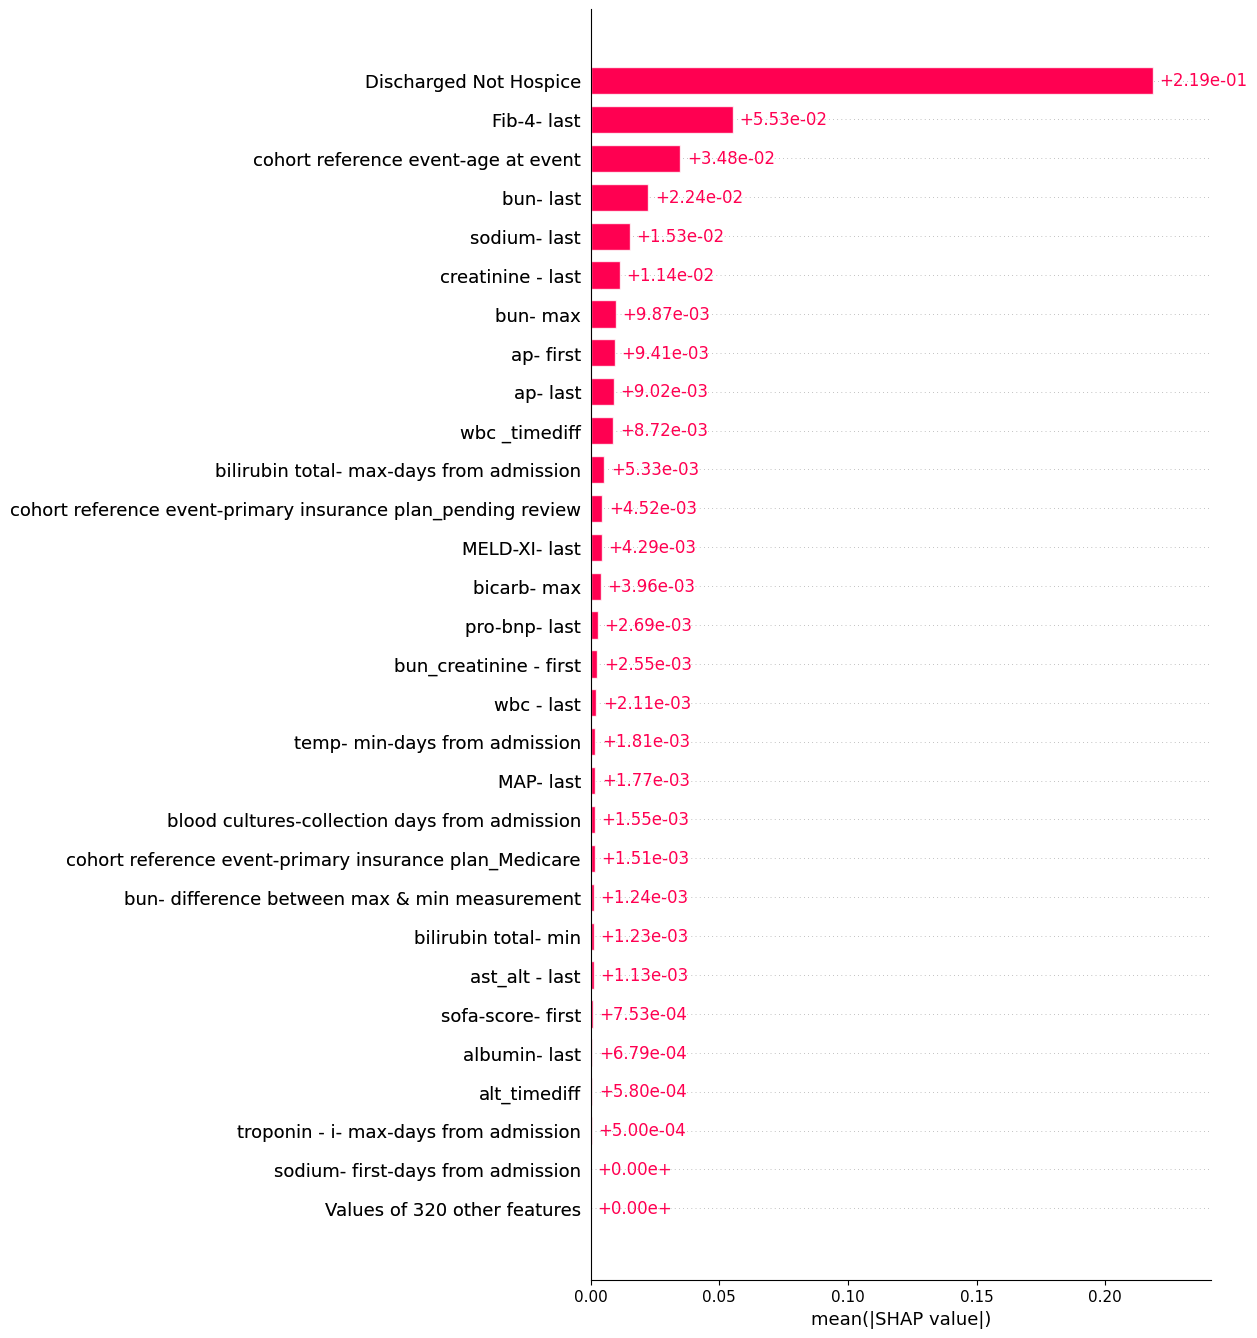

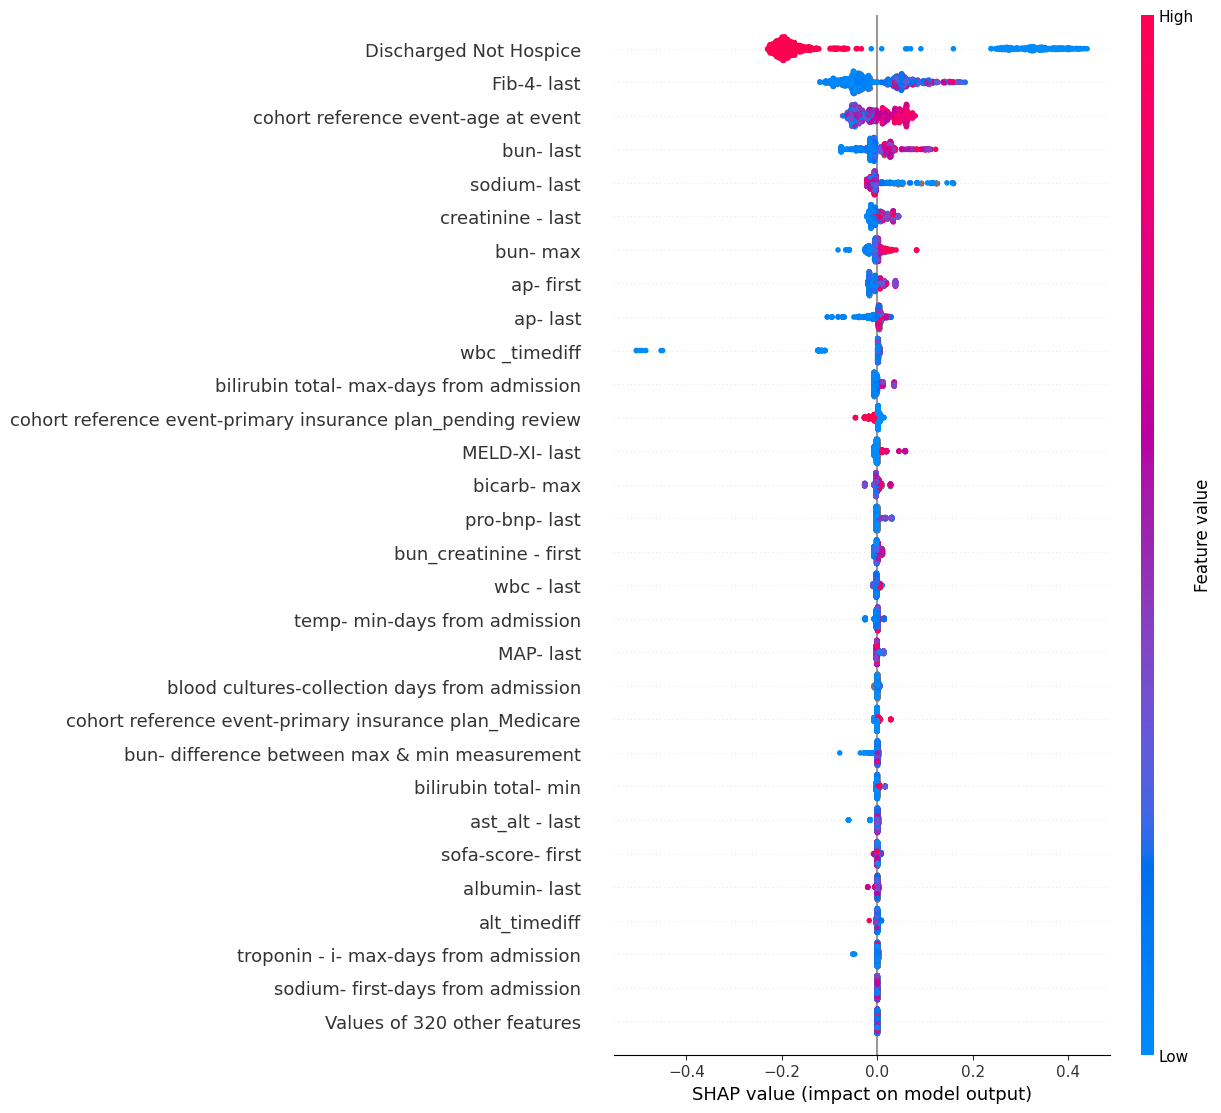

In [55]:
shap_values = shap.Explainer(clf_xgb1).shap_values(X_test1)
explainer = shap.Explainer(clf_xgb1)
shap_values = explainer(X_test1)

shap.plots.bar(shap_values[:], max_display= 30)

shap.plots.beeswarm(shap_values[:], max_display= 30)

### Generate Scores for test dataset

In [931]:
Scores = clf_xgb1.predict_proba(G3_Test)
Scores = pd.DataFrame(Scores)
Scores.index = G3_Test.index
Scores.columns= ['Survival (0) Probability', 'Mortality (1) Probability']
Scores.to_csv('Datathon_Scores.csv', index = True)